In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

import prettytable
import time
import sys
sys.setrecursionlimit(18000)

from PIL import Image
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data import random_split

from model0409 import FixCapsNet
from images_show import ImageShow

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc= 0.
#defined 
try:
    print(len(test_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list=train_loss_list,
                train_acc_list=train_acc_list,
                test_loss_list=test_loss_list,
                test_acc_list=test_acc_list,
                test_auc_list=test_auc_list,
                val_loss_list=val_loss_list,
                val_acc_list=val_acc_list,
                )

In [4]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((308,308)),
                               transforms.CenterCrop((299, 299)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
    }

In [5]:
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
image_path = os.path.abspath(os.path.join(root_path,"skin_lesion"))
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),
                                      transform=data_transform["val"])
train_num = len(train_dataset)
test_num = len(test_dataset)

img_sample = Image.open(test_dataset.imgs[1][0])
n_channels = np.array(img_sample).shape[2]#(H,W,C)

data_list = train_dataset.class_to_idx #
cla_dict = dict((val, key) for key, val in data_list.items())
n_classes  = len(data_list)
print(f'Using {n_classes} types.')

# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(f'{img_title}.json', 'w') as json_file:#class_indices
    json_file.write(json_str)

BatchSize = 128
T_size = 31
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 10]) 
print(f'Using {nw} dataloader workers every process.')
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BatchSize,pin_memory=pin_memory,
                                           shuffle=True, num_workers=nw)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=T_size,pin_memory=pin_memory,
                                          shuffle=False, num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num, test_num))

Using 7 types.
Using 10 dataloader workers every process.
using 51699 images for training, 828 images for validation.


In [6]:
# Create capsule network.
conv_outputs = 128 #128_Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6
output_unit_size = 16
img_size = 299
network = FixCapsNet(conv_inputs= n_channels,
                     conv_outputs=conv_outputs,
                     num_primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     output_unit_size=output_unit_size,
                     num_classes=n_classes,
                     init_weights=True)

network = network.to(device)
summary(network,(n_channels,img_size,img_size))
# network

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 135, 135]         369,152
              ReLU-2        [-1, 128, 135, 135]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [8]:
def confusion_matrix(evl_result):

    plt.style.use("seaborn")#classic
    plt.yticks(range(n_classes),cla_dict.values())
    plt.xticks(range(n_classes),cla_dict.values())    
    plt.title("Confusion Matrix")
    plt.imshow(evl_result,cmap=plt.cm.Greens)
    for i in range(len(evl_result)):
        for j in range(len(evl_result[i])):
            plt.text(j,i,int(evl_result[i][j]))

    plt.colorbar()
    plt.savefig(f"./tmp/{img_title}/{suf}/Confusion Matrix.png",dpi=128)

In [9]:
def self_scores(opt="scores"):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Type','Precision', 'Recall', 'F1','Accuracy']    
    accuracy = float(torch.sum(evl_result.diagonal())/torch.sum(evl_result))

    for i in range(n_classes):
        pre = float(evl_result[i][i] / torch.sum(evl_result,0)[i])#
        recal = float(evl_result[i][i] / torch.sum(evl_result,1)[i])#torch.sum(result_table[i])
        F1 = pre * recal * 2 / (pre + recal + 1e-7)
        result_table.add_row([cla_dict[i], round(pre, 4), round(recal, 3), round(F1, 3)," "])

    result_table.add_row(["Total:", " ", " ", " ",round(accuracy,4)])
    print(result_table)

In [10]:
# Converts batches of class indices to classes of one-hot vectors.
def to_one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

In [11]:
def train(epoch):
    network.train()
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    print(f'Epoch: [{epoch}] {img_title} ==> Training ...')
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        
        # target = torch.as_tensor(target, dtype=torch.int64)#for windows

        batch_idx += 1
        target_indices = target
        target_one_hot = to_one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        optimizer.zero_grad()
        output = network(data)

        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        
        loss = network.loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f}, ACC:{:.5f}%".format(batch_idx,len(train_loader),
                                                           loss,
                                                           r_pre/(batch_idx*BatchSize),))
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)    
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    
    print(f'Train_Loss: {epoch_loss},ACC:{round(float(epoch_acc),3)}%')   
    scheduler.step()

In [12]:
def test():
    network.eval()
    global best_acc,evl_result,evl_tmp_result,net_parameters
    cor_loss,correct,tmp_size, Acc=  0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    steps_num = len(test_loader)#len(test_loader) * T_size
    tmp_size = T_size
    print(f'\033[66m{img_title} ==> testing ...\033[0m')
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):

            batch_idx +=1
            target_indices = target
            #torch.Size([128, 7]),tensor([[0., 0., 0., 0., 0., 1., 0.],...,[0., 0., 0., 0., 0., 1., 0.]])
            target_one_hot = to_one_hot(target_indices, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output = network(data)#torch.Size([batch_size, 7, 16, 1])        
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]  
               
            if batch_idx % steps_num == 0 and test_num % T_size != 0:
                tmp_size = test_num % T_size

            for i in range(tmp_size):
                pred_y = pred.numpy()         
                evl_tmp_result[target_indices[i]][pred[i]] +=1 
    
    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result)   
    accuracy = 100. * float(torch.div(diag_sum,all_sum)) 
    test_acc_list.append(accuracy)
    
    print(f"Test_Acc:\033[1;32m{round(float(accuracy),3)}%\033[0m")

    if accuracy > best_acc:
        best_acc = accuracy
        evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
        torch.save(network.state_dict(), save_PATH)
        torch.save(evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pt')
        
    print(f'Best_ACC[\033[1;32m{round(float(best_acc),3)}%\033[0m]')

In [13]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: ./tmp/{img_title}/{suf}')
else:
#     !mkdir -p ./tmp/{img_title}/{suf} #linux
    !md E:\Jupyter\woodman\Caps\FixCaps\tmp\{img_title}\{suf} #windows
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
print(save_PATH)

suf:0428_235816
./tmp/HAM10000/0428_235816/best_HAM10000_0428_235816.pth


子目录或文件 #windows 已经存在。
处理: #windows 时出错。


In [14]:
num_epochs = 100

In [15]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()
print('Finished Training')

Epoch: [1] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.38601, ACC:0.33284%
[404/404] Loss0.32642, ACC:0.38324%
Train_Loss: 0.39728353120902976,ACC:0.383%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.696%
Best_ACC[83.696%]
Epoch: [2] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.32718, ACC:0.46515%
[404/404] Loss0.33495, ACC:0.48434%
Train_Loss: 0.33715239041807626,ACC:0.484%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.42%
Best_ACC[84.42%]
Epoch: [3] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.29290, ACC:0.52479%
[404/404] Loss0.29852, ACC:0.53084%
Train_Loss: 0.3112286090260685,ACC:0.531%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.092%
Best_ACC[84.42%]
Epoch: [4] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.30838, ACC:0.56111%
[404/404] Loss0.27565, ACC:0.55914%
Train_Loss: 0.29435441683572117,ACC:0.559%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.903%
Best_ACC[84.903%]
Epoch: [5] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.28852, ACC:0.57387%
[404/404] Loss0.30127, ACC:0.57408%
Train_Loss: 0.2848170110494784,ACC:0.574%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.386%
Best_ACC[85.386%]
Epoch: [6] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25047, ACC:0.57925%
[404/404] Loss0.25580, ACC:0.57909%
Train_Loss: 0.28245305336347903,ACC:0.579%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.145%
Best_ACC[85.386%]
Epoch: [7] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25415, ACC:0.58006%
[404/404] Loss0.26100, ACC:0.57886%
Train_Loss: 0.2820235600713456,ACC:0.579%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.816%
Best_ACC[85.386%]
Epoch: [8] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.30287, ACC:0.57468%
[404/404] Loss0.27813, ACC:0.57586%
Train_Loss: 0.284078134943058,ACC:0.576%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.541%
Best_ACC[85.386%]
Epoch: [9] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.28808, ACC:0.56962%
[404/404] Loss0.28273, ACC:0.57300%
Train_Loss: 0.2860040833233016,ACC:0.573%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.628%
Best_ACC[85.628%]
Epoch: [10] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.28282, ACC:0.57851%
[404/404] Loss0.30446, ACC:0.58308%
Train_Loss: 0.2817313224814906,ACC:0.583%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.386%
Best_ACC[85.628%]
Epoch: [11] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.27241, ACC:0.58555%
[404/404] Loss0.27235, ACC:0.58789%
Train_Loss: 0.27744386647597397,ACC:0.588%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.957%
Best_ACC[86.957%]
Epoch: [12] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.26207, ACC:0.60427%
[404/404] Loss0.25296, ACC:0.60423%
Train_Loss: 0.26806541119176563,ACC:0.604%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.614%
Best_ACC[89.614%]
Epoch: [13] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.26833, ACC:0.61228%
[404/404] Loss0.25733, ACC:0.61510%
Train_Loss: 0.26004862412810326,ACC:0.615%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.923%
Best_ACC[89.614%]
Epoch: [14] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22701, ACC:0.62724%
[404/404] Loss0.24479, ACC:0.63067%
Train_Loss: 0.25177712937687885,ACC:0.631%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.575%
Best_ACC[89.614%]
Epoch: [15] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25353, ACC:0.63765%
[404/404] Loss0.25042, ACC:0.64103%
Train_Loss: 0.24399326678992497,ACC:0.641%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.681%
Best_ACC[89.614%]
Epoch: [16] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23905, ACC:0.64585%
[404/404] Loss0.23673, ACC:0.64569%
Train_Loss: 0.24284195837260472,ACC:0.646%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.164%
Best_ACC[89.614%]
Epoch: [17] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.26852, ACC:0.64082%
[404/404] Loss0.23214, ACC:0.64639%
Train_Loss: 0.24222742010018614,ACC:0.647%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.527%
Best_ACC[89.614%]
Epoch: [18] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.26589, ACC:0.63981%
[404/404] Loss0.26241, ACC:0.63989%
Train_Loss: 0.24650706409817874,ACC:0.64%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.855%
Best_ACC[89.855%]
Epoch: [19] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.27994, ACC:0.63142%
[404/404] Loss0.23856, ACC:0.63101%
Train_Loss: 0.2515410181171823,ACC:0.631%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.614%
Best_ACC[89.855%]
Epoch: [20] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24630, ACC:0.62937%
[404/404] Loss0.22811, ACC:0.63022%
Train_Loss: 0.25211083619753916,ACC:0.63%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.749%
Best_ACC[89.855%]
Epoch: [21] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.26438, ACC:0.63022%
[404/404] Loss0.20319, ACC:0.63337%
Train_Loss: 0.2517137300997677,ACC:0.634%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.87%
Best_ACC[89.855%]
Epoch: [22] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25765, ACC:0.63796%
[404/404] Loss0.23110, ACC:0.63964%
Train_Loss: 0.24704446794815582,ACC:0.64%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.473%
Best_ACC[89.855%]
Epoch: [23] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24881, ACC:0.65130%
[404/404] Loss0.23969, ACC:0.65167%
Train_Loss: 0.23958229505927256,ACC:0.652%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.647%
Best_ACC[89.855%]
Epoch: [24] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25118, ACC:0.66468%
[404/404] Loss0.22987, ACC:0.66350%
Train_Loss: 0.23302171807182898,ACC:0.664%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.473%
Best_ACC[89.855%]
Epoch: [25] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19855, ACC:0.67574%
[404/404] Loss0.19323, ACC:0.67619%
Train_Loss: 0.2262090728203259,ACC:0.676%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.198%
Best_ACC[89.855%]
Epoch: [26] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23862, ACC:0.67064%
[404/404] Loss0.22288, ACC:0.67180%
Train_Loss: 0.22679969908134773,ACC:0.672%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.957%
Best_ACC[89.855%]
Epoch: [27] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22795, ACC:0.66781%
[404/404] Loss0.21337, ACC:0.67336%
Train_Loss: 0.22642608997550343,ACC:0.674%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.44%
Best_ACC[89.855%]
Epoch: [28] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22101, ACC:0.66720%
[404/404] Loss0.23850, ACC:0.66710%
Train_Loss: 0.22969662925541992,ACC:0.667%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.179%
Best_ACC[89.855%]
Epoch: [29] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21119, ACC:0.65884%
[404/404] Loss0.23247, ACC:0.65954%
Train_Loss: 0.2354687606491665,ACC:0.66%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.353%
Best_ACC[89.855%]
Epoch: [30] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.26010, ACC:0.65671%
[404/404] Loss0.22725, ACC:0.65524%
Train_Loss: 0.23891105484401826,ACC:0.655%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.609%
Best_ACC[89.855%]
Epoch: [31] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.29687, ACC:0.65633%
[404/404] Loss0.24830, ACC:0.65890%
Train_Loss: 0.23677591326655728,ACC:0.659%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.836%
Best_ACC[89.855%]
Epoch: [32] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23173, ACC:0.66433%
[404/404] Loss0.25445, ACC:0.66341%
Train_Loss: 0.2336277924478054,ACC:0.664%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.092%
Best_ACC[89.855%]
Epoch: [33] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19631, ACC:0.66820%
[404/404] Loss0.21344, ACC:0.67275%
Train_Loss: 0.2276795097801945,ACC:0.673%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:21.135%
Best_ACC[89.855%]
Epoch: [34] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24410, ACC:0.68328%
[404/404] Loss0.22496, ACC:0.68675%
Train_Loss: 0.22024697378867925,ACC:0.687%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:79.589%
Best_ACC[89.855%]
Epoch: [35] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19473, ACC:0.69210%
[404/404] Loss0.20850, ACC:0.69355%
Train_Loss: 0.2141322677604633,ACC:0.694%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[92.391%]
Epoch: [36] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21095, ACC:0.69094%
[404/404] Loss0.21751, ACC:0.69353%
Train_Loss: 0.2137482770082384,ACC:0.694%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.546%
Best_ACC[92.391%]
Epoch: [37] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19747, ACC:0.69957%
[404/404] Loss0.21408, ACC:0.69843%
Train_Loss: 0.21314099947414775,ACC:0.699%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.923%
Best_ACC[92.391%]
Epoch: [38] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22979, ACC:0.68839%
[404/404] Loss0.19480, ACC:0.68791%
Train_Loss: 0.21839461612081765,ACC:0.688%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.217%
Best_ACC[92.391%]
Epoch: [39] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21882, ACC:0.68143%
[404/404] Loss0.21528, ACC:0.68062%
Train_Loss: 0.22381144846872528,ACC:0.681%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.493%
Best_ACC[92.391%]
Epoch: [40] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25401, ACC:0.67617%
[404/404] Loss0.24950, ACC:0.67582%
Train_Loss: 0.22706989401785455,ACC:0.676%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.454%
Best_ACC[92.391%]
Epoch: [41] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21919, ACC:0.67787%
[404/404] Loss0.27366, ACC:0.67746%
Train_Loss: 0.22657021304758468,ACC:0.678%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.58%
Best_ACC[92.391%]
Epoch: [42] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23470, ACC:0.67787%
[404/404] Loss0.19132, ACC:0.67947%
Train_Loss: 0.22414532432904338,ACC:0.68%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:38.527%
Best_ACC[92.391%]
Epoch: [43] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20502, ACC:0.69040%
[404/404] Loss0.23558, ACC:0.69264%
Train_Loss: 0.21675269449553866,ACC:0.693%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.633%
Best_ACC[92.633%]
Epoch: [44] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18350, ACC:0.70239%
[404/404] Loss0.23868, ACC:0.70369%
Train_Loss: 0.21026866049459664,ACC:0.704%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.063%
Best_ACC[92.633%]
Epoch: [45] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22227, ACC:0.71020%
[404/404] Loss0.21986, ACC:0.71185%
Train_Loss: 0.2054684762612428,ACC:0.712%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.614%
Best_ACC[92.633%]
Epoch: [46] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19827, ACC:0.71229%
[404/404] Loss0.21196, ACC:0.71424%
Train_Loss: 0.2037228446564462,ACC:0.714%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.372%
Best_ACC[92.633%]
Epoch: [47] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21842, ACC:0.71291%
[404/404] Loss0.22716, ACC:0.71281%
Train_Loss: 0.20400277064135758,ACC:0.713%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.01%
Best_ACC[92.633%]
Epoch: [48] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18481, ACC:0.70796%
[404/404] Loss0.20531, ACC:0.70802%
Train_Loss: 0.2085089234653676,ACC:0.708%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.024%
Best_ACC[92.633%]
Epoch: [49] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20977, ACC:0.69879%
[404/404] Loss0.21103, ACC:0.69804%
Train_Loss: 0.2148578278720379,ACC:0.698%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.01%
Best_ACC[92.633%]
Epoch: [50] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23607, ACC:0.68928%
[404/404] Loss0.21594, ACC:0.69199%
Train_Loss: 0.21766023050145347,ACC:0.692%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.406%
Best_ACC[92.633%]
Epoch: [51] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19909, ACC:0.69059%
[404/404] Loss0.22245, ACC:0.68967%
Train_Loss: 0.21944259638243382,ACC:0.69%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.957%
Best_ACC[92.633%]
Epoch: [52] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21817, ACC:0.69500%
[404/404] Loss0.21699, ACC:0.69628%
Train_Loss: 0.2158413151334418,ACC:0.696%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.802%
Best_ACC[92.633%]
Epoch: [53] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21948, ACC:0.70108%
[404/404] Loss0.19661, ACC:0.70345%
Train_Loss: 0.21006946291516324,ACC:0.704%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.367%
Best_ACC[92.633%]
Epoch: [54] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18150, ACC:0.71577%
[404/404] Loss0.19154, ACC:0.71771%
Train_Loss: 0.20335692890209728,ACC:0.718%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[92.633%]
Epoch: [55] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21086, ACC:0.72656%
[404/404] Loss0.18224, ACC:0.72610%
Train_Loss: 0.19792350499641778,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.425%
Best_ACC[92.633%]
Epoch: [56] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17244, ACC:0.72973%
[404/404] Loss0.17407, ACC:0.72763%
Train_Loss: 0.19721980743331485,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.338%
Best_ACC[92.633%]
Epoch: [57] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21091, ACC:0.72819%
[404/404] Loss0.18862, ACC:0.72705%
Train_Loss: 0.19714185001678985,ACC:0.727%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.546%
Best_ACC[92.633%]
Epoch: [58] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20541, ACC:0.72266%
[404/404] Loss0.19060, ACC:0.72026%
Train_Loss: 0.20130428579626697,ACC:0.72%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:76.812%
Best_ACC[92.633%]
Epoch: [59] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22704, ACC:0.71245%
[404/404] Loss0.20518, ACC:0.71036%
Train_Loss: 0.20750622307457547,ACC:0.711%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[92.633%]
Epoch: [60] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22227, ACC:0.70050%
[404/404] Loss0.19878, ACC:0.70166%
Train_Loss: 0.2118965862779924,ACC:0.702%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:70.411%
Best_ACC[92.633%]
Epoch: [61] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23526, ACC:0.70185%
[404/404] Loss0.21746, ACC:0.70289%
Train_Loss: 0.213358718533032,ACC:0.703%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.029%
Best_ACC[92.633%]
Epoch: [62] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18686, ACC:0.70514%
[404/404] Loss0.24903, ACC:0.70645%
Train_Loss: 0.20926108901010881,ACC:0.707%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.372%
Best_ACC[92.633%]
Epoch: [63] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21951, ACC:0.71221%
[404/404] Loss0.21995, ACC:0.71618%
Train_Loss: 0.20424710177253969,ACC:0.716%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.372%
Best_ACC[92.633%]
Epoch: [64] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20052, ACC:0.72679%
[404/404] Loss0.17960, ACC:0.72567%
Train_Loss: 0.19736403673149572,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.357%
Best_ACC[93.357%]
Epoch: [65] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18965, ACC:0.73426%
[404/404] Loss0.19490, ACC:0.73383%
Train_Loss: 0.19251765229619375,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[93.841%]
Epoch: [66] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24207, ACC:0.73693%
[404/404] Loss0.17653, ACC:0.73424%
Train_Loss: 0.19270339501228664,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[93.841%]
Epoch: [67] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21500, ACC:0.73217%
[404/404] Loss0.21016, ACC:0.73372%
Train_Loss: 0.1927790597523793,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.995%
Best_ACC[93.841%]
Epoch: [68] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19521, ACC:0.72765%
[404/404] Loss0.21241, ACC:0.72737%
Train_Loss: 0.1967119868512791,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.15%
Best_ACC[93.841%]
Epoch: [69] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21698, ACC:0.71937%
[404/404] Loss0.23316, ACC:0.71716%
Train_Loss: 0.2029387226494232,ACC:0.717%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.734%
Best_ACC[93.841%]
Epoch: [70] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20610, ACC:0.71113%
[404/404] Loss0.22567, ACC:0.71098%
Train_Loss: 0.20728331343224732,ACC:0.711%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:51.691%
Best_ACC[93.841%]
Epoch: [71] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19457, ACC:0.71450%
[404/404] Loss0.20008, ACC:0.71189%
Train_Loss: 0.20701223903215757,ACC:0.712%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:45.29%
Best_ACC[93.841%]
Epoch: [72] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18863, ACC:0.71446%
[404/404] Loss0.21642, ACC:0.71525%
Train_Loss: 0.2049879057720156,ACC:0.715%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:73.309%
Best_ACC[93.841%]
Epoch: [73] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20555, ACC:0.72714%
[404/404] Loss0.19598, ACC:0.72488%
Train_Loss: 0.1992209061685175,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[93.841%]
Epoch: [74] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17711, ACC:0.73395%
[404/404] Loss0.18655, ACC:0.73281%
Train_Loss: 0.1938228665454553,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.184%
Best_ACC[93.841%]
Epoch: [75] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19318, ACC:0.74176%
[404/404] Loss0.20534, ACC:0.73890%
Train_Loss: 0.1890788253138561,ACC:0.739%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.599%
Best_ACC[93.841%]
Epoch: [76] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17044, ACC:0.74532%
[404/404] Loss0.21066, ACC:0.74377%
Train_Loss: 0.18813551335346582,ACC:0.744%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.478%
Best_ACC[93.841%]
Epoch: [77] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17916, ACC:0.74513%
[404/404] Loss0.17298, ACC:0.74337%
Train_Loss: 0.18870839598302794,ACC:0.744%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[93.841%]
Epoch: [78] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20353, ACC:0.73097%
[404/404] Loss0.16670, ACC:0.73441%
Train_Loss: 0.19355974099276088,ACC:0.735%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.923%
Best_ACC[93.841%]
Epoch: [79] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19145, ACC:0.72258%
[404/404] Loss0.21191, ACC:0.72623%
Train_Loss: 0.19848184626881438,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.459%
Best_ACC[93.841%]
Epoch: [80] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17778, ACC:0.72034%
[404/404] Loss0.20995, ACC:0.72039%
Train_Loss: 0.20186762271983788,ACC:0.721%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.425%
Best_ACC[93.841%]
Epoch: [81] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20964, ACC:0.72269%
[404/404] Loss0.17703, ACC:0.72076%
Train_Loss: 0.20229976159511226,ACC:0.721%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.082%
Best_ACC[94.082%]
Epoch: [82] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20786, ACC:0.72095%
[404/404] Loss0.21715, ACC:0.72258%
Train_Loss: 0.20104894610029636,ACC:0.723%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.097%
Best_ACC[94.082%]
Epoch: [83] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17766, ACC:0.72997%
[404/404] Loss0.20725, ACC:0.73161%
Train_Loss: 0.19604192209420818,ACC:0.732%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.338%
Best_ACC[94.082%]
Epoch: [84] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17702, ACC:0.74114%
[404/404] Loss0.19430, ACC:0.74027%
Train_Loss: 0.1894705145813451,ACC:0.74%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.807%
Best_ACC[94.807%]
Epoch: [85] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19003, ACC:0.75015%
[404/404] Loss0.19677, ACC:0.74882%
Train_Loss: 0.1842463369859327,ACC:0.749%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[94.807%]
Epoch: [86] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18777, ACC:0.74830%
[404/404] Loss0.18217, ACC:0.74841%
Train_Loss: 0.18435173149746242,ACC:0.749%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[94.807%]
Epoch: [87] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19595, ACC:0.74927%
[404/404] Loss0.17027, ACC:0.74766%
Train_Loss: 0.18444050287846292,ACC:0.748%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.357%
Best_ACC[94.807%]
Epoch: [88] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20100, ACC:0.74354%
[404/404] Loss0.18714, ACC:0.74254%
Train_Loss: 0.18856521153656564,ACC:0.743%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.357%
Best_ACC[94.807%]
Epoch: [89] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17739, ACC:0.73519%
[404/404] Loss0.17854, ACC:0.73397%
Train_Loss: 0.19412447146997594,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.459%
Best_ACC[94.807%]
Epoch: [90] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21667, ACC:0.73097%
[404/404] Loss0.20612, ACC:0.72925%
Train_Loss: 0.19824858902409526,ACC:0.729%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.44%
Best_ACC[94.807%]
Epoch: [91] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21468, ACC:0.72610%
[404/404] Loss0.17308, ACC:0.72538%
Train_Loss: 0.20059389875519393,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[94.807%]
Epoch: [92] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.14689, ACC:0.72842%
[404/404] Loss0.18222, ACC:0.72532%
Train_Loss: 0.1984940124399001,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.889%
Best_ACC[94.807%]
Epoch: [93] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18748, ACC:0.73654%
[404/404] Loss0.17911, ACC:0.73619%
Train_Loss: 0.19309189425099013,ACC:0.736%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.338%
Best_ACC[94.807%]
Epoch: [94] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18077, ACC:0.75089%
[404/404] Loss0.20850, ACC:0.74745%
Train_Loss: 0.1868575736142621,ACC:0.748%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[94.807%]
Epoch: [95] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16170, ACC:0.75232%
[404/404] Loss0.16545, ACC:0.75309%
Train_Loss: 0.18183232331187418,ACC:0.753%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.928%
Best_ACC[94.928%]
Epoch: [96] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20051, ACC:0.75085%
[404/404] Loss0.19243, ACC:0.75412%
Train_Loss: 0.18155841920340415,ACC:0.754%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[94.928%]
Epoch: [97] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17508, ACC:0.75418%
[404/404] Loss0.17474, ACC:0.75306%
Train_Loss: 0.18200835777391303,ACC:0.753%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.894%
Best_ACC[95.894%]
Epoch: [98] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19235, ACC:0.74656%
[404/404] Loss0.17041, ACC:0.74633%
Train_Loss: 0.1860285724079845,ACC:0.747%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.478%
Best_ACC[95.894%]
Epoch: [99] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21461, ACC:0.73526%
[404/404] Loss0.19183, ACC:0.73878%
Train_Loss: 0.1916426109647987,ACC:0.739%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.184%
Best_ACC[95.894%]
Epoch: [100] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16442, ACC:0.73097%
[404/404] Loss0.20235, ACC:0.73097%
Train_Loss: 0.19595591757114572,ACC:0.731%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.478%
Best_ACC[95.894%]
Finished Training


In [16]:
show.conclusion(img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [97]
[Test]  ACC:95.89%.


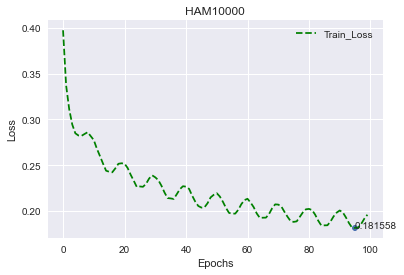

In [17]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

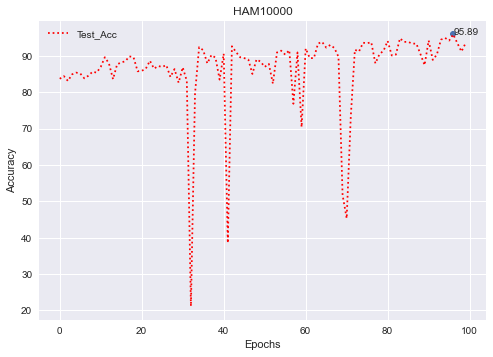

In [18]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [19]:
self_scores()

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.7778  | 0.913  |  0.84 |          |
|  bcc   |   0.8077  | 0.808  | 0.808 |          |
|  bkl   |   0.9219  | 0.894  | 0.908 |          |
|   df   |   0.4545  | 0.833  | 0.588 |          |
|  mel   |   0.9062  | 0.853  | 0.879 |          |
|   nv   |   0.9864  | 0.983  | 0.985 |          |
|  vasc  |    1.0    |  0.7   | 0.824 |          |
| Total: |           |        |       |  0.9589  |
+--------+-----------+--------+-------+----------+


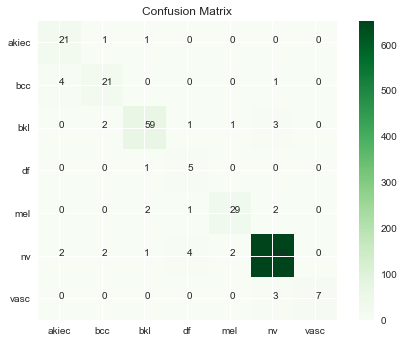

In [20]:
confusion_matrix(evl_result)

In [21]:
network.load_state_dict(torch.load(save_PATH))
for i in range(5):
    test()

HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.894%
Best_ACC[95.894%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.894%
Best_ACC[95.894%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.894%
Best_ACC[95.894%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.894%
Best_ACC[95.894%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.894%
Best_ACC[95.894%]


In [23]:
self_scores()

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.7778  | 0.913  |  0.84 |          |
|  bcc   |   0.8077  | 0.808  | 0.808 |          |
|  bkl   |   0.9219  | 0.894  | 0.908 |          |
|   df   |   0.4545  | 0.833  | 0.588 |          |
|  mel   |   0.9062  | 0.853  | 0.879 |          |
|   nv   |   0.9864  | 0.983  | 0.985 |          |
|  vasc  |    1.0    |  0.7   | 0.824 |          |
| Total: |           |        |       |  0.9589  |
+--------+-----------+--------+-------+----------+


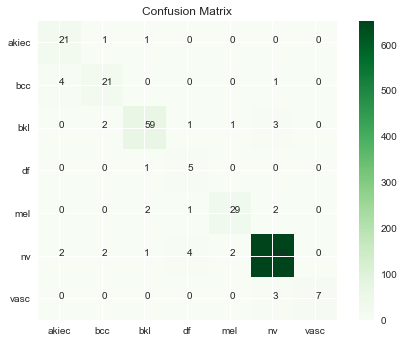

In [24]:
confusion_matrix(evl_result)

In [25]:
# #save
s1 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s1)
s2 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s2)

In [ ]:
torch.cuda.memory.empty_cache()